In [2]:
#Load in necessary modules and packages

import os
import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
import matplotlib.pyplot as plt
from signal_utils import *
%matplotlib inline
import keras
from keras.models import model_from_json
from tl_model.inner_hair_cell2018 import inner_hair_cell_potential
from tl_model.auditory_nerve2018 import auditory_nerve_fiber
from dynamic_compressor import *
import warnings
warnings.filterwarnings("ignore")

### 2.1 
Simulate cochlear reponses for 3 TL models: One normal-hearing (NH), one with a sloping high-frequency hearing loss (Slope25), and one with an equal hearing loss across all frequencies (Flat25).

In [3]:
# General parameters
L = 70. # specify the desired SPL of the input
fs_nn = 20e3 # CoNNear requires 20kHz
cf_nn = np.loadtxt('cf_connear.txt')*1e3 # Frequency channels of the tl model
#print(f"Cf_nn: {cf_nn}")

# read the wavfile
wavfile = 'example.wav'
fs, signal = sio_wav.read(wavfile) 
# scipy returns a quantized signal - scale it back
if signal.dtype == 'int16':
    nb_bits = 16 # -> 16-bit wav files
elif signal.dtype == 'int32':
    nb_bits = 32 # -> 32-bit wav files
max_nb_bit = float(2 ** (nb_bits - 1))
signal = signal / (max_nb_bit + 1.0) # scale the signal to [-1.0,1.0]

#cut some part out of it
sample_duration = 2 #needs to be in seconds
onset_duration = 0 #omit silence in the beginning (secs)
num_samples = int(sample_duration * fs)
onset_samples = int(onset_duration * fs)
signal = signal[onset_samples:onset_samples+num_samples]
#adjust the SPL to the desired level
signal = adjust_spl(signal, L)

#Prepare for feeding to the CoNNear models
if fs != fs_nn :
    print("Resampling signal to " + str(fs_nn) + " Hz")
    signal_nn = sp_sig.resample_poly(signal, fs_nn, fs)
else:
    signal_nn = signal
signal_nn = np.expand_dims(signal_nn, axis=0) #The CoNNear model needs an (1,x,1) input, hence expanding the dimensions
signal_nn = np.expand_dims(signal_nn, axis=2)

Resampling signal to 20000.0 Hz


In [4]:
signal_nn.shape # the shape of the input signal

(1, 39360, 1)

In [5]:
#load in the NH CoNNear model (reference)
json_file = open("connear/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear_nh = model_from_json(loaded_model_json)
connear_nh.load_weights("connear/Gmodel.h5")
connear_nh.summary()

#generate the NH output
bmm_NH = connear_nh.predict(signal_nn)
bmm_NH = bmm_NH[0,:,:] * 1e-6 # scaling for bm

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_input (InputLayer)     [(None, None, 1)]         0         
_________________________________________________________________
model_1 (Functional)         (None, None, 201)         11689984  
Total params: 11,689,984
Trainable params: 11,689,984
Non-trainable params: 0
_________________________________________________________________


In [6]:
#load in the sloping HI CoNNear model
json_file = open("connear_slope25/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear_hislope = model_from_json(loaded_model_json)
connear_hislope.load_weights("connear_slope25/Gmodel.h5")
#connear_hislope.summary()

#generate the sloping HI output
bmm_HIslope = connear_hislope.predict(signal_nn)
bmm_HIslope = bmm_HIslope[0,:,:] * 1e-6 # scaling for bm

In [7]:
#load in the flat HI CoNNear model
json_file = open("connear_flat25/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear_hiflat = model_from_json(loaded_model_json)
connear_hiflat.load_weights("connear_flat25/Gmodel.h5")
#connear_hiflat.summary()

#generate the flat HI output
bmm_HIflat = connear_hiflat.predict(signal_nn)
bmm_HIflat = bmm_HIflat[0,:,:] * 1e-6 # scaling for bm

In [8]:
# All three TL outputs have the same format (time x frequency)
N = bmm_NH.shape[0] # length of the time dimension
t = np.linspace(0, N/fs_nn, N) # time vector
bmm_NH.shape # shape of the cochlear response

(38848, 201)

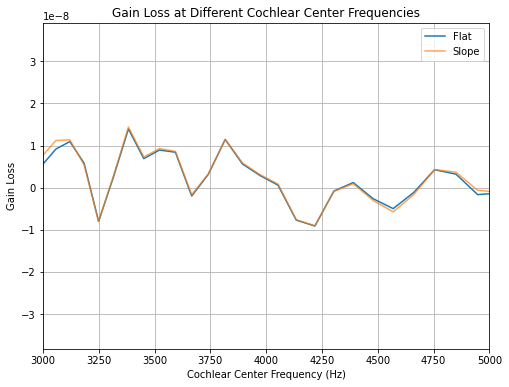

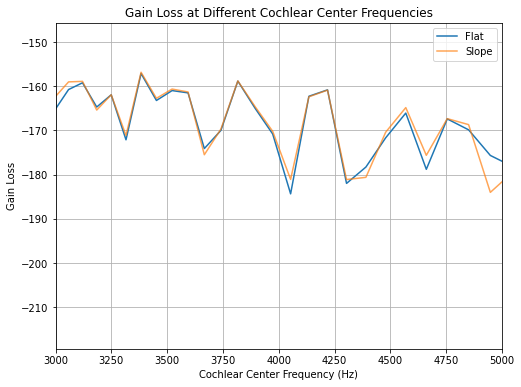

Index closest to 4kHz: 56


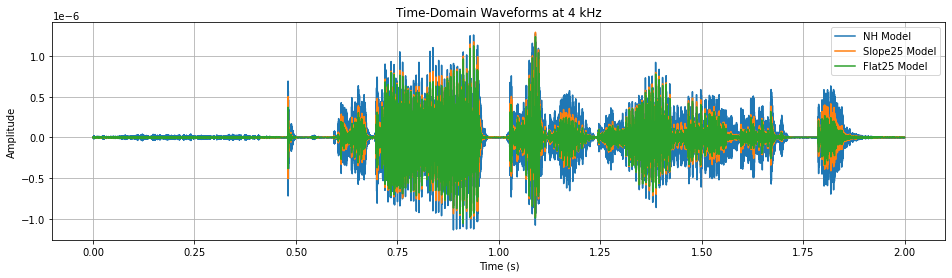

In [9]:
#                                           COMPARISON -> change some things -> this is point 2.1

# Calculate dB gain loss for each frequency channel
difference_flat = bmm_NH - bmm_HIflat
dB_difference_flat = 20 * np.log10(np.abs(difference_flat))


# Calculate dB gain loss for each frequency channel
difference_slope = bmm_NH - bmm_HIslope
dB_difference_slope = 20 * np.log10(np.abs(difference_slope))

# Plot gain loss
plt.figure(figsize=(8, 6))
plt.plot(cf_nn, difference_flat[1], label="Flat")
plt.plot(cf_nn, difference_slope[1], label="Slope", alpha=0.7)
plt.legend()
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss')
plt.title('Gain Loss at Different Cochlear Center Frequencies')
plt.xlim([3000, 5000])
plt.grid(True)
plt.show()

# Plot gain loss in dB
plt.figure(figsize=(8, 6))
plt.plot(cf_nn, dB_difference_flat[1], label="Flat")
plt.plot(cf_nn, dB_difference_slope[1], label="Slope", alpha=0.7)
plt.legend()
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss')
plt.title('Gain Loss at Different Cochlear Center Frequencies')
plt.xlim([3000, 5000])
plt.grid(True)
plt.show()


# Find the index of the cochlear center frequency closest to 4 kHz
target_cf = 4000  # Target center frequency in Hz
cf_index = np.argmin(np.abs(cf_nn - target_cf))
print(f"Index closest to 4kHz: {cf_index}")

# Extract the time-domain waveforms at cf_index
waveform_nh = bmm_NH[:, cf_index]
waveform_hislope = bmm_HIslope[:, cf_index]
waveform_hiflat = bmm_HIflat[:, cf_index]

# Create the time vector
time = np.linspace(0, sample_duration, waveform_nh.shape[0])

# Plot the waveforms
plt.figure(figsize=(16, 4))
plt.plot(time, waveform_nh, label='NH Model')
plt.plot(time, waveform_hislope, label='Slope25 Model')
plt.plot(time, waveform_hiflat, label='Flat25 Model')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-Domain Waveforms at 4 kHz')
plt.legend()
plt.grid(True)
plt.show()

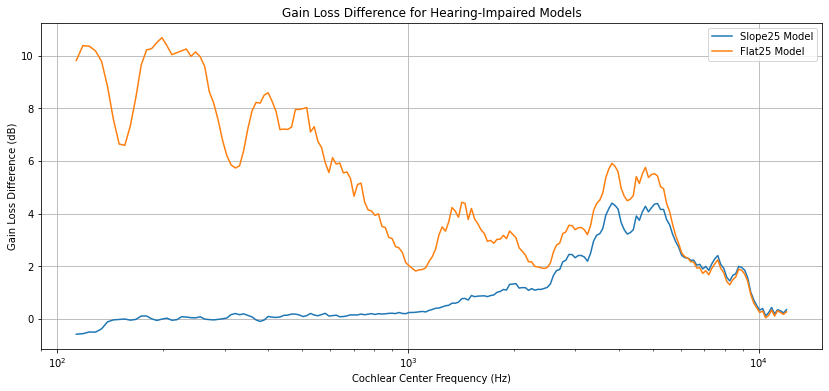

In [38]:
start_sample = 26400  # Start sample index of the time window
end_sample = 45600  # End sample index of the time window

# Create arrays to store gain loss differences
gain_loss_difference_hislope = np.zeros_like(cf_nn)
gain_loss_difference_hiflat = np.zeros_like(cf_nn)

# Iterate over each center frequency
for i, cf_index in enumerate(range(len(cf_nn))):
    # Extract time-domain waveforms within the specified window
    waveform_nh_window = bmm_NH[start_sample:end_sample, cf_index]
    waveform_hislope_window = bmm_HIslope[start_sample:end_sample, cf_index]
    waveform_hiflat_window = bmm_HIflat[start_sample:end_sample, cf_index]

    # Calculate RMS gain loss difference
    rms_normal = np.sqrt(np.mean((waveform_nh_window) ** 2, axis=0))
    rms_hislope = np.sqrt(np.mean((waveform_hislope_window) ** 2, axis=0))
    rms_hiflat = np.sqrt(np.mean((waveform_hiflat_window) ** 2, axis=0))

    # Convert RMS difference to dB scale
    gain_loss_difference_hislope[i] = 20 * np.log10(rms_normal) - 20*np.log10(rms_hislope)
    gain_loss_difference_hiflat[i] = 20 * np.log10(rms_normal) - 20 * np.log10(rms_hiflat)

# Plot the gain loss functions
plt.figure(figsize=(14, 6))
plt.semilogx(cf_nn, gain_loss_difference_hislope, label='Slope25 Model')
plt.semilogx(cf_nn, gain_loss_difference_hiflat, label='Flat25 Model')
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss Difference (dB)')
plt.title('Gain Loss Difference for Hearing-Impaired Models')
plt.legend()
plt.grid(True)
plt.show()

### 2.3
Example of a level-independent, frequency-dependent gain prescription applied to the same signal

0.08442878723144531
dB factors for the 4 frequencies - slope: [0.04 0.12 0.66 2.09]
dB factors for the 4 frequencies - flat: [4.   1.01 1.61 2.8 ]


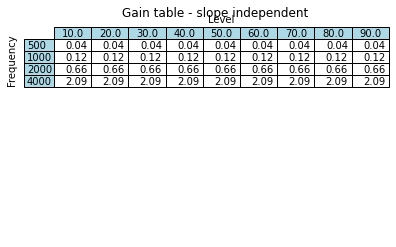

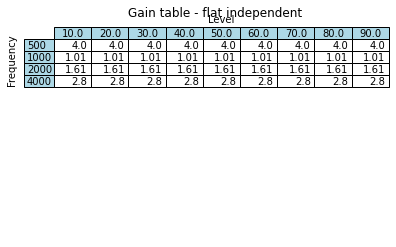

shape processed slope: (94464,)


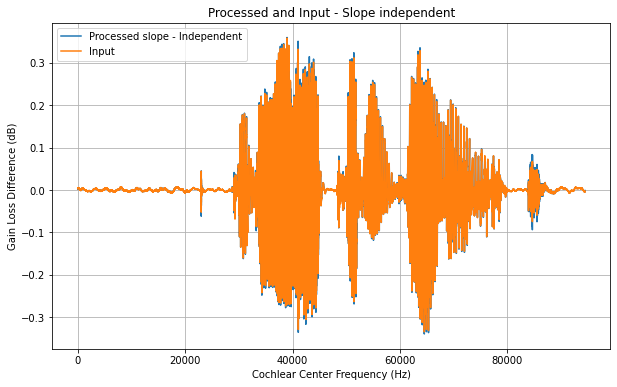

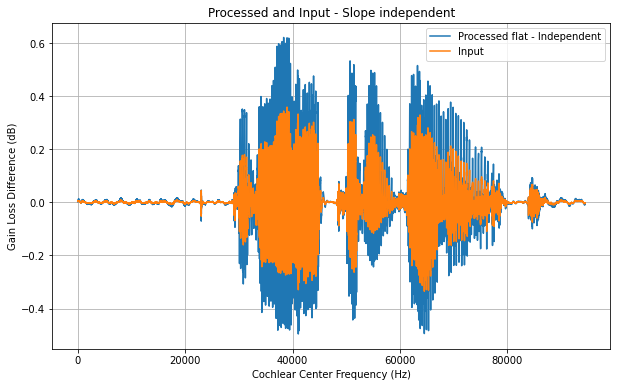

In [62]:
# For a level-independent sloping hearing loss, a 5-dB sloping gain can be 
# applied after 1 kHz, shaping the gain table as follows:
# Define the two dimensions of the gain table
frequencies = np.array([500,1000,2000,4000]) # frequency vector in Hz
levels = np.arange(10.,91.,10.) # level vector - 10 to 90 dB-SPL with a step of 10 dB | SPL: sound pressure level
# Define the gains to be applied - here a (4x1) vector is given to apply frequency-dependent gain across 4 frequencies


gain_loss_slope_onfreqs_dB = np.zeros(len(frequencies))
gain_loss_flat_onfreqs_dB = np.zeros(len(frequencies))


# make 4 cases:
#   Two for each HI model (slope, flat)
#   - frequency dependent, level independent
#   - frequency dependent, level dependent

# half value rule -> originally take 0.5 * amplitude in dB from the gain-loss function at that specific frequency
# level dependent -> sube el gain dependiendo del level: subir más a niveles más bajos o a un nivel específico, etc...

half_value_slope = 0.5 * gain_loss_difference_hislope
half_value_flat = 0.5 * gain_loss_difference_hiflat

indices = [np.abs(cf_nn-freq).argmin() for freq in frequencies] # getting indices for the objective frequencies

# values for the indices on half value rule 
for i in range(len(frequencies)):
    gain_loss_slope_onfreqs_dB[i] = np.round(half_value_slope[indices[i]], 2)
    gain_loss_flat_onfreqs_dB[i] = np.round(half_value_flat[indices[i]], 2)

print(f"dB factors for the 4 frequencies - slope: {gain_loss_slope_onfreqs_dB}")
print(f"dB factors for the 4 frequencies - flat: {gain_loss_flat_onfreqs_dB}")
    

gains_slope_independent = np.array([gain_loss_slope_onfreqs_dB]).T # if one-dimensional then the array is repeated across the other dimension of the table
gains_flat_independent = np.array([gain_loss_flat_onfreqs_dB]).T 

# Form the gain table: the dimensions (frequency x level) must be the same as the frequencies and levels vectors 
# The gain values can be derived from the gains matrix or defined manually below
Gtable_slope_independent = np.ones((frequencies.size,levels.size))* gains_slope_independent # can also be directly defined as an (f x L) matrix
Gtable_flat_independent = np.ones((frequencies.size,levels.size))*gains_flat_independent # can also be directly defined as an (f x L) matrix



# show the Gain Table - slope independent
# each element corresponds to the gain that will be applied to the respective frequency and level of the input signal
plt.table(cellText=Gtable_slope_independent, rowLabels=frequencies, colLabels=levels, loc="upper left", rowColours=['lightblue']*frequencies.size, colColours=['lightblue']*levels.size)
plt.text(0.48,1,'Level')
plt.text(-0.12,0.72,'Frequency', rotation=90)
plt.axis('off')
plt.title("Gain table - slope independent")
plt.show()

# show the Gain Table - flat independent
# each element corresponds to the gain that will be applied to the respective frequency and level of the input signal
plt.table(cellText=Gtable_flat_independent, rowLabels=frequencies, colLabels=levels, loc="upper left", rowColours=['lightblue']*frequencies.size, colColours=['lightblue']*levels.size)
plt.text(0.48,1,'Level')
plt.text(-0.12,0.72,'Frequency', rotation=90)
plt.axis('off')
plt.title("Gain table - flat independent")
plt.show()



# Process the signal using the dynamic compression algorithm and the created gain table
#signal_processed = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable, freq=frequencies, gt=levels)
signal_processed_slope = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable_slope_independent, freq=frequencies, gt=levels)
signal_processed_flat = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable_flat_independent, freq=frequencies, gt=levels)
print(f"shape processed slope: {signal_processed_slope.shape}")



# Plot processed signal - slope independent
plt.figure(figsize=(10, 6))
plt.plot(signal_processed_slope, label='Processed slope - Independent')
plt.plot(signal, label='Input')
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss Difference (dB)')
plt.title('Processed and Input - Slope independent')
plt.legend()
plt.grid(True)
plt.show()

# Plot processed signal - flat independent
plt.figure(figsize=(10, 6))
plt.plot(signal_processed_flat, label='Processed flat - Independent')
plt.plot(signal, label='Input')
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss Difference (dB)')
plt.title('Processed and Input - Slope independent')
plt.legend()
plt.grid(True)
plt.show()

INDICES: 152
dB factors for the 4 frequencies - slope: [[ 0.04  0.04  0.04  0.04  0.04 -0.    0.    0.01  0.01]
 [ 0.12  0.12  0.12  0.12  0.12 -0.01  0.    0.02  0.04]
 [ 0.66  0.66  0.66  0.66  0.66 -0.07  0.03  0.12  0.21]
 [ 2.09  2.09  2.09  2.09  2.09 -0.21  0.08  0.38  0.67]]
dB factors for the 4 frequencies - flat: [[ 4.    4.    4.    4.    4.   -0.4   0.16  0.72  1.28]
 [ 1.01  1.01  1.01  1.01  1.01 -0.1   0.04  0.18  0.32]
 [ 1.6   1.6   1.6   1.6   1.6  -0.16  0.06  0.29  0.51]
 [ 2.8   2.8   2.8   2.8   2.8  -0.28  0.11  0.5   0.89]]


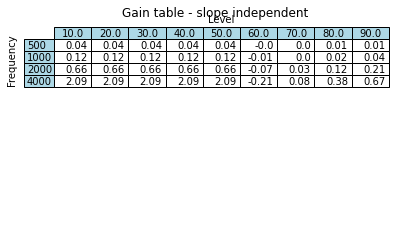

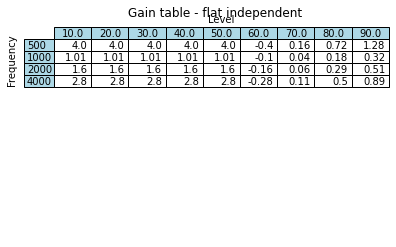

shape processed slope: (94464,)


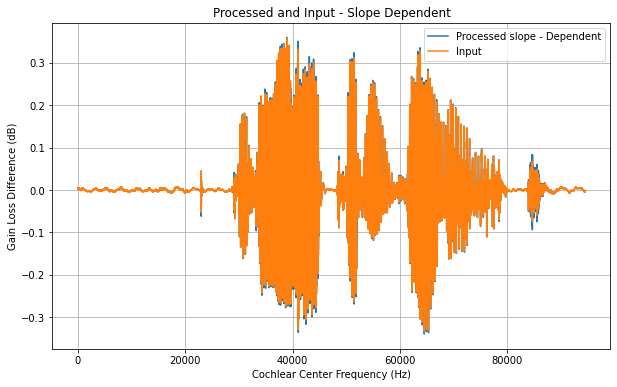

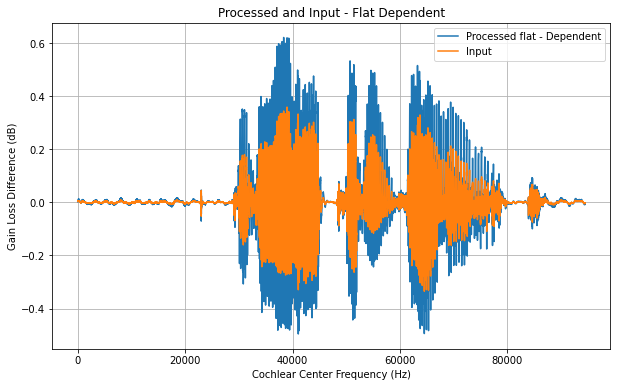

In [86]:
# Define the two dimensions of the gain table
frequencies = np.array([500,1000,2000,4000]) # same frequency vector as for independent
levels = np.arange(10.,91.,10.) 

gain_slope_onfreqs_dB = []
gain_flat_onfreqs_dB = []

# level dependent -> sube el gain dependiendo del level: subir más a niveles más bajos o a un nivel específico, etc...

indices = [np.abs(cf_nn-freq).argmin() for freq in frequencies] # getting indices for the objective frequencies

print(f"INDICES: {indices[0]}")
# values for the indices on half value rule 
count = 0.5
for i in range(len(levels)): # 10 -> 90
    
    gain_temp_slope = np.array([np.round(gain_loss_difference_hislope[indices[fi]], 2) for fi in range(len(frequencies))])
    gain_temp_flat = np.array([np.round(gain_loss_difference_hiflat[indices[fi]], 2) for fi in range(len(frequencies))])
    
    if i <=4: 
        gain_temp_slope *= 0.5 # half value rule
        gain_temp_flat *= 0.5 
    
    else:
        gain_temp_slope *= (levels[i]*10**-2 - count) # from 50 to 90
        gain_temp_flat *= (levels[i]*10**-2 - count )
    
    gain_slope_onfreqs_dB.append(np.round(gain_temp_slope, 2))
    gain_flat_onfreqs_dB.append(np.round(gain_temp_flat, 2))
    
    count += 0.03

    
gain_slope_dependent = np.array(gain_slope_onfreqs_dB).T
gain_flat_dependent = np.array(gain_flat_onfreqs_dB).T

print(f"dB factors for the 4 frequencies - slope: {gain_slope_dependent}")
print(f"dB factors for the 4 frequencies - flat: {gain_flat_dependent}")
    

# Form the gain table: the dimensions (frequency x level) must be the same as the frequencies and levels vectors 
# The gain values can be derived from the gains matrix or defined manually below
Gtable_slope_dependent = np.ones((frequencies.size,levels.size))* gain_slope_dependent # can also be directly defined as an (f x L) matrix
Gtable_flat_dependent = np.ones((frequencies.size,levels.size))*gain_flat_dependent # can also be directly defined as an (f x L) matrix



# show the Gain Table - slope independent
# each element corresponds to the gain that will be applied to the respective frequency and level of the input signal
plt.table(cellText=Gtable_slope_dependent, rowLabels=frequencies, colLabels=levels, loc="upper left", rowColours=['lightblue']*frequencies.size, colColours=['lightblue']*levels.size)
plt.text(0.48,1,'Level')
plt.text(-0.12,0.72,'Frequency', rotation=90)
plt.axis('off')
plt.title("Gain table - slope independent")
plt.show()

# show the Gain Table - flat independent
# each element corresponds to the gain that will be applied to the respective frequency and level of the input signal
plt.table(cellText=Gtable_flat_dependent, rowLabels=frequencies, colLabels=levels, loc="upper left", rowColours=['lightblue']*frequencies.size, colColours=['lightblue']*levels.size)
plt.text(0.48,1,'Level')
plt.text(-0.12,0.72,'Frequency', rotation=90)
plt.axis('off')
plt.title("Gain table - flat independent")
plt.show()



# Process the signal using the dynamic compression algorithm and the created gain table
#signal_processed = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable, freq=frequencies, gt=levels)
signal_processed_slope = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable_slope_dependent, freq=frequencies, gt=levels)
signal_processed_flat = dynamic_compression(signal, fs_signal=fs, Gtable=Gtable_flat_dependent, freq=frequencies, gt=levels)
print(f"shape processed slope: {signal_processed_slope.shape}")



# Plot processed signal - slope dependent
plt.figure(figsize=(10, 6))
plt.plot(signal_processed_slope, label='Processed slope - Dependent')
plt.plot(signal, label='Input')
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss Difference (dB)')
plt.title('Processed and Input - Slope Dependent')
plt.legend()
plt.grid(True)
plt.show()

# Plot processed signal - flat dependent
plt.figure(figsize=(10, 6))
plt.plot(signal_processed_flat, label='Processed flat - Dependent')
plt.plot(signal, label='Input')
plt.xlabel('Cochlear Center Frequency (Hz)')
plt.ylabel('Gain Loss Difference (dB)')
plt.title('Processed and Input - Flat Dependent')
plt.legend()
plt.grid(True)
plt.show()

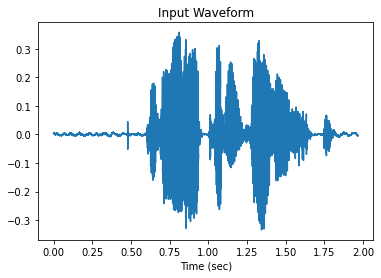

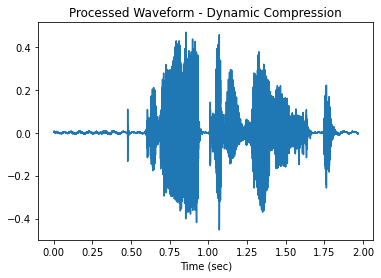

In [14]:
t = np.arange(len(signal))/fs
tp = np.arange(len(signal_processed))/fs
plt.figure()
plt.plot(t,signal), plt.title("Input Waveform")
plt.xlabel('Time (sec)');
plt.figure()
plt.plot(tp,signal_processed), plt.title("Processed Waveform - Dynamic Compression")
plt.xlabel('Time (sec)');

We can see that the input and processed signals for the Slope HI model have nearly the same amplitude when compared. This technique is insufficient because what we seek is signal amplification to make up for lost information.

The modification is better for the flat model because the gain was greater than the signal. Better compensates for hearing loss.

### 2.4
Use the processed signal as inputs to the HI cochlear models 

In [18]:
#Prepare the processed signal for the CoNNear models
if fs != fs_nn :
    print("Resampling signal to " + str(fs_nn) + " Hz")
    signal_processed_nn = sp_sig.resample_poly(signal_processed, fs_nn, fs)
else:
    signal_processed_nn = signal_processed
signal_processed_nn = np.expand_dims(signal_processed_nn, axis=0) #The CoNNear model needs an (1,x,1) input, hence expanding the dimensions
signal_processed_nn = np.expand_dims(signal_processed_nn, axis=2)

Resampling signal to 20000.0 Hz


In [19]:
#generate the sloping HI output for the processed signal
bmm_HIslope_processed = connear_hislope.predict(signal_processed_nn)
bmm_HIslope_processed = bmm_HIslope_processed[0,:,:] * 1e-6 # scaling for bm

#generate the flat HI output for the processed signal
bmm_HIflat_processed = connear_hiflat.predict(signal_processed_nn)
bmm_HIflat_processed = bmm_HIflat_processed[0,:,:] * 1e-6 # scaling for bm

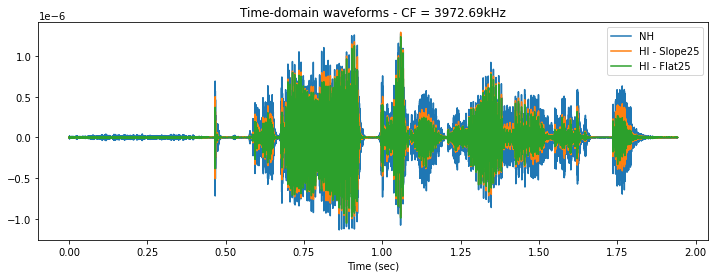

In [40]:
frequency = 4000 # frequency to plot
channel = (np.abs(cf_nn - frequency)).argmin() # find channel with the closest frequency 
t = np.linspace(0, N/fs_nn, N) # time vector

plt.figure(figsize=(12,4))
plt.plot(t, bmm_NH[:,channel], label = "NH")
plt.plot(t, bmm_HIslope[:,channel], label = "HI - Slope25")
plt.plot(t, bmm_HIflat[:,channel], label = "HI - Flat25")
plt.title("Time-domain waveforms - CF = " + "%.2f" % cf_nn[channel] + "kHz")
plt.legend()
plt.xlabel('Time (sec)');
#plt.xlim([0.55,0.95]);

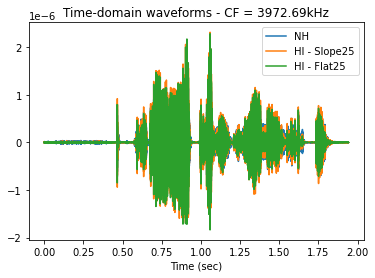

In [21]:
frequency = 4000 # frequency to plot
channel = (np.abs(cf_nn - frequency)).argmin() # find channel with the closest frequency 
t = np.linspace(0, N/fs_nn, N) # time vector

plt.plot(t,bmm_NH[:,channel], label = "NH")
plt.plot(t,bmm_HIslope_processed[:,channel], label = "HI - Slope25")
plt.plot(t,bmm_HIflat_processed[:,channel], label = "HI - Flat25")
plt.title("Time-domain waveforms - CF = " + "%.2f" % cf_nn[channel] + "kHz")
plt.legend()
plt.xlabel('Time (sec)');